## Lab02 Report

##### Pranisaa Charnparttaravanit st121720

## AlexNet

In this section of Lab02, AlexNet model was implemented on the CIFAR-10 dataset. It is important to note that under this lab reports, there will be in the total of 4 versions of the AlexNet and they are as follows:

1. AlexNet with Sequential API (AlexNet Sequential)
2. AlexNet with Sequential API with Local-Response Normalization (AlexNet Sequential with LRN )
3. AlexNet with nn.Module (AlexNet nn.Module)
4. AlexNet with nn.Module with Local-Response Normalization (AlexNet nn.Module with LRN)

All 4 variations of AlexNet employed the exact same optimizer as well as the loss functions which are as follows:

* criterion = nn.CrossEntropyLoss()
* optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

The number of trainable parameters of each model is as follows:

1. AlexNet Sequential has 58,322,314 trainable parameters
2. AlexNet Sequential with LRN has 58,322,314 trainable parameters
3. AlexNet nn.Module has 57,044,810 trainable parameters
4. AlexNet nn.Module with LRN has 57,044,810 trainable parameter

The models were trained for 10 epochs with the batch size of 4 and the performances at the 10th epoch of each model and the test accuracies are as follows:

* AlexNet Sequential: Train acc = 86.32%, Val acc = 77.06%, Test acc = 79.20%
* AlexNet Sequential with LRN: Train acc = 87.66%, Val acc = 79.43%, Test acc = 80.22%
* AlexNet nn.Module: Train acc = 86.83%, Val acc = 79.37% , Test acc = 79.96%
* AlexNet nn.Module with LRN: Train acc = 85.11%, Val acc = 74.90% , Test acc = 77.05%

NOTE: The comparison between the test set results can be found at the discussion section below

#### Libaries

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F
from IPython.display import clear_output

### 1. Prepare Dataset

In [2]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and split into training, validation, and test sets

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=preprocess)

# Split the training set into training and validation sets randomly.
# CIFAR-10 train contains 50,000 examples, so let's split 80%/20%.

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

# Download the test set. If you use data augmentation transforms for the training set,
# you'll want to use a different transformer here.

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=preprocess)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                              shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Configured device: ", device)

Configured device:  cuda:2


### 2. Define models

#### 2.1 AlexNet with Sequential API with no LRN

In [4]:
# Simple module to flatten a batched feature map tensor into a batched vector tensor

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

# AlexNet-like model using the Sequential API

NUM_CLASSES = 10

alexnet_sequential = nn.Sequential(
    
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.AdaptiveAvgPool2d((6, 6)),   #<<<< do anything to get 6*6 any featrue maps!
    Flatten(),
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    
    nn.Linear(4096, NUM_CLASSES)
)

#### 2.2 AlexNet with Sequential API with LRN added

In [5]:
# AlexNet-like model using the Sequential API

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

NUM_CLASSES = 10

alexnet_sequential_LRN = nn.Sequential(
    
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    nn.LocalResponseNorm(5, alpha = 0.0001, beta = 0.75, k = 2.0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.LocalResponseNorm(5, alpha = 0.0001, beta = 0.75, k = 2.0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.AdaptiveAvgPool2d((6, 6)),   #<<<< do anything to get 6*6 any featrue maps!
    Flatten(),
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    
    nn.Linear(4096, NUM_CLASSES)
)

#### 2.3 AlexNet with nn.Module

In [6]:
class AlexNetModule(nn.Module):
    '''
    An AlexNet-like CNN

    Attributes
    ----------
    num_classes : int
        Number of classes in the final multinomial output layer
    features : Sequential
        The feature extraction portion of the network
    avgpool : AdaptiveAvgPool2d
        Convert the final feature layer to 6x6 feature maps by average pooling if they are not already 6x6
    classifier : Sequential
        Classify the feature maps into num_classes classes
    '''
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha = 0.0001, beta = 0.75, k = 2.0),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha = 0.0001, beta = 0.75, k = 2.0),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### 2.4 AlexNet with nn.Module with LRN added

In [7]:
class AlexNetModule_LRN(nn.Module):
    '''
    An AlexNet-like CNN

    Attributes
    ----------
    num_classes : int
        Number of classes in the final multinomial output layer
    features : Sequential
        The feature extraction portion of the network
    avgpool : AdaptiveAvgPool2d
        Convert the final feature layer to 6x6 feature maps by average pooling if they are not already 6x6
    classifier : Sequential
        Classify the feature maps into num_classes classes
    '''
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### 3. Define Train and Evaluation Functions

In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model function

    Train a PyTorch model for a given number of epochs.
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        if (epoch+1) % 5 == 0:        
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the train/validation dataset according to which phase we're in
            
            for inputs, labels in dataloaders[phase]:

                # Inputs is one batch of input images, and labels is a corresponding vector of integers
                # labeling each image in the batch. First, we move these tensors to our target device.
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out any parameter gradients that have previously been calculated. Parameter
                # gradients accumulate over as many backward() passes as we let them, so they need
                # to be zeroed out after each optimizer step.

                optimizer.zero_grad()

                # Instruct PyTorch to track gradients only if this is the training phase, then run the
                # forward propagation and optionally the backward propagation step for this iteration.

                with torch.set_grad_enabled(phase == 'train'):
                    # The inception model is a special case during training because it has an auxiliary
                    # output used to encourage discriminative representations in the deeper feature maps.
                    # We need to calculate loss for both outputs. Otherwise, we have a single output to
                    # calculate the loss on.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    preds = nn.functional.softmax(outputs, dim=1)   
                    _, preds = torch.max(outputs, 1)

                    # Backpropagate only if in training phase

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Gather our summary statistics
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start
            
            if (epoch+1) % 5 == 0:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                print("Epoch time taken: ", elapsed_epoch)

            # If this is the best model on the validation set so far, deep copy it

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), f'AlexNet_weights/{weights_name}.pth')
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

#         print()

    # Output summary statistics, load the best weight set, and return results
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

In [9]:
def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []
    trues = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())   
            loss = criterion(predictions, labels.long())
            
            predictions = nn.functional.softmax(predictions, dim=1)            
            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
                       
            predicteds.append(predicted)
            trues.append(labels)            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator),predicteds, trues

In [10]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history):
    plt.plot(loss_acc_history, label = 'Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'Validation')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

### 4. Train the models

#### 4.1 Define models to train

In [11]:
alexnet_sequential = alexnet_sequential 
alexnet_sequential_LRN = alexnet_sequential_LRN
alexnet_nn = AlexNetModule(10)
alexnet_nn_LRN = AlexNetModule_LRN(10)

models = [alexnet_sequential, alexnet_sequential_LRN, alexnet_nn, alexnet_nn_LRN]
model_names = ['AlexNet Sequential', 'AlexNet Sequential with LRN', 'AlexNet nn.Module', 'AlexNet nn.Module with LRN']
# criterion = criterion.to(device)

#### 4.1 Loss and Optimizer Functions

In [12]:
criterion = nn.CrossEntropyLoss()

optimizers = []
for model in models:
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizers.append(optimizer)

#### 4.2 Move everything to the configured device

##### Let's check the availability of GPU...

In [13]:
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Configured device: ", device)

Configured device:  cuda:2


In [14]:
for model in models:
    model = model.to(device)
    
criterion = criterion.to(device)

#### 4.3 Count the parameters

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for i,model in enumerate(models):
    print(f'The model {model_names[i]} has {count_parameters(model):,} trainable parameters')# Train the model

The model AlexNet Sequential has 58,322,314 trainable parameters
The model AlexNet Sequential with LRN has 58,322,314 trainable parameters
The model AlexNet nn.Module has 57,044,810 trainable parameters
The model AlexNet nn.Module with LRN has 57,044,810 trainable parameters


#### 4.4 Prepare the dataloader

In [16]:
dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

#### 4.5 Train the models

Training: AlexNet Sequential
Epoch 4/9
----------
train Loss: 0.7042 Acc: 0.7588
Epoch time taken:  134.26278352737427
val Loss: 0.8178 Acc: 0.7179
Epoch time taken:  147.69260048866272
Epoch 9/9
----------
train Loss: 0.3956 Acc: 0.8632
Epoch time taken:  213.99458050727844
val Loss: 0.6965 Acc: 0.7706
Epoch time taken:  233.68587732315063
Training complete in 28m 43s
Best val Acc: 0.786100


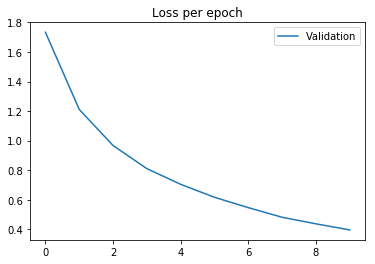

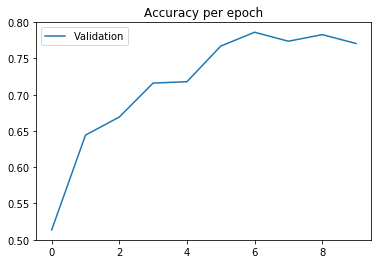

Training: AlexNet Sequential with LRN
Epoch 4/9
----------
train Loss: 0.7149 Acc: 0.7515
Epoch time taken:  235.82744073867798
val Loss: 0.7430 Acc: 0.7429
Epoch time taken:  257.42596554756165
Epoch 9/9
----------
train Loss: 0.3565 Acc: 0.8766
Epoch time taken:  162.44293856620789
val Loss: 0.6181 Acc: 0.7943
Epoch time taken:  177.94630789756775
Training complete in 39m 46s
Best val Acc: 0.794300


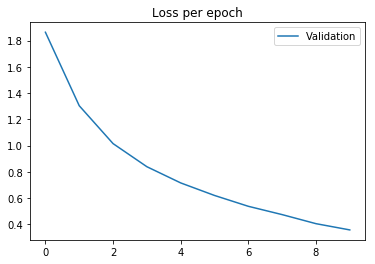

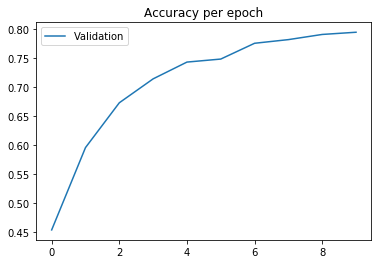

Training: AlexNet nn.Module
Epoch 4/9
----------
train Loss: 0.7286 Acc: 0.7461
Epoch time taken:  166.6973361968994
val Loss: 0.7928 Acc: 0.7282
Epoch time taken:  182.3241925239563
Epoch 9/9
----------
train Loss: 0.3761 Acc: 0.8683
Epoch time taken:  162.443785905838
val Loss: 0.6540 Acc: 0.7937
Epoch time taken:  178.31673002243042
Training complete in 30m 27s
Best val Acc: 0.793700


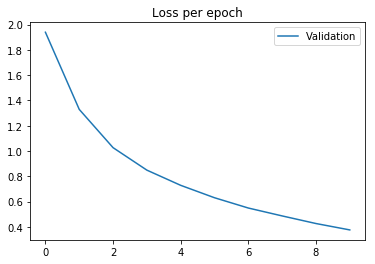

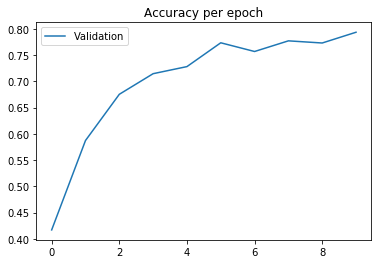

Training: AlexNet nn.Module with LRN
Epoch 4/9
----------
train Loss: 0.7338 Acc: 0.7460
Epoch time taken:  142.65125727653503
val Loss: 0.7363 Acc: 0.7465
Epoch time taken:  158.92026042938232
Epoch 9/9
----------
train Loss: 0.4290 Acc: 0.8511
Epoch time taken:  134.85807490348816
val Loss: 0.7652 Acc: 0.7490
Epoch time taken:  150.18662881851196
Training complete in 26m 39s
Best val Acc: 0.770500


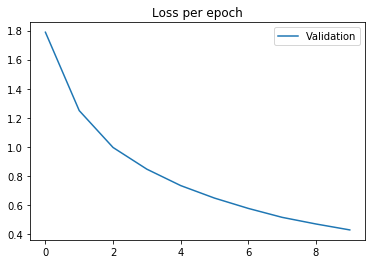

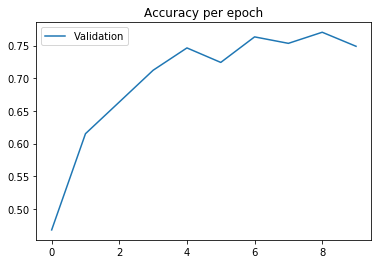

In [17]:
# num_epochs = 2
for i, model in enumerate(models):
    print(f'Training: {model_names[i]}')
    best_model, val_acc_history, loss_acc_history = train_model(model, dataloaders, criterion, optimizers[i], 10, model_names[i])
    plot_data(val_acc_history, loss_acc_history)
    print('='*30)

### 5. Results

In [18]:
for i, model in enumerate(models):
    print(f'Model: {model_names[i]}')
    model.load_state_dict(torch.load(f'AlexNet_weights/{model_names[i]}.pth'))
    test_loss, test_acc, test_pred_label, test_true_label  = evaluate(model, test_dataloader, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Model: AlexNet Sequential
Test Loss: 0.640 | Test Acc: 79.20%
Model: AlexNet Sequential with LRN
Test Loss: 0.605 | Test Acc: 80.22%
Model: AlexNet nn.Module
Test Loss: 0.652 | Test Acc: 79.96%
Model: AlexNet nn.Module with LRN
Test Loss: 0.727 | Test Acc: 77.05%
